# Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
####
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) #SET SIZE OF ALL SEABORN PLOTS
import sklearn as sk

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Binarizer, Normalizer, OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#####
from sklearn import set_config
set_config(display="diagram")

# Functions

In [ ]:
def class_reporter(y_test, y_pred, title):

  report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
  report_df = classification_report_extractor(report_df, title)

  report_print_out = classification_report(y_test, y_pred)

  return report_df, report_print_out

def classification_report_extractor(report_df, clf):
  '''
  cp_w_dict: pd.DataFrame
  -pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

  clf: str
  -Classifier name
  '''
  df = report_df.reset_index()
  df = df.loc[(0,4),:]
  df['clf'] = clf

  df = df.rename(columns={'index':'view'})

  return df

def cm_labeler(title=str, xlab=str, ylab=str):
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

def corr_plotter(corrmatrix_dataframe:pd.DataFrame, title:str):
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corrmatrix_dataframe, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corrmatrix_dataframe, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.title(title)

def gridsearch_df_viewer(gridsearch__cv_results_):
  # search.cv_results_
  to_drop = ['mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'split0_test_score', 
            'split1_test_score',
            'split2_test_score', 
            'split3_test_score', 
            'split4_test_score']

  df = pd.DataFrame(gridsearch__cv_results_)
  df = df.drop(columns=to_drop)
  df = df.sort_values('rank_test_score')
  df = df.reset_index()

  return df.head(5)


def top10plotter(coeffs_df, title):

  ## Sort the features by the absolute value of their coefficient
  coeffs_df["abs_value"] = coeffs_df["value"].apply(lambda x: abs(x))
  coeffs_df = coeffs_df.drop(columns='value')
  coeffs_df = coeffs_df.sort_values("abs_value", ascending=False)
  coeffs_df = coeffs_df.head(10)

  fig, ax = plt.subplots(1, 1, figsize=(12, 7))
  sns.barplot(x="feature",
              y="abs_value",
              data=coeffs_df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
  ax.set_title(title, fontsize=25)
  ax.set_ylabel("Coef", fontsize=22)
  ax.set_xlabel("Feature Name", fontsize=22)

  return coeffs_df

# Data Importation

In [ ]:
# path_ = '/Volumes/GoogleDrive/My Drive/_599/Capstone/Data/pure_ripa_final.csv'
path_ = '/content/drive/MyDrive/_599/Capstone/Data/pure_ripa_final.csv'
df = pd.read_csv(path_)
print('DataFrame shape', df.shape)
df.head(3)

DataFrame shape (652452, 27)


,stop_id,pid,reason_for_stop,exp_years,date_stop,time_stop,stopduration,officer_assignment_key,assignment,beat,...,resultkey,result,race,date,time_period,light,month,day_of_week,hour_stopped,temp
0,10000,1,Traffic Violation,26,2018-07-15,19:31:37,5,1,"Patrol, traffic enforcement, field operations",313.0,...,3,Citation for infraction,White,2018-07-15,2,1,7,6,19,74.5
1,10001,1,Reasonable Suspicion,1,2018-07-15,16:16:00,120,1,"Patrol, traffic enforcement, field operations",721.0,...,6,Custodial Arrest without warrant,Hispanic/Latino/a,2018-07-15,1,1,7,6,16,80.7
2,10002,1,Reasonable Suspicion,10,2018-07-15,19:40:37,30,1,"Patrol, traffic enforcement, field operations",124.0,...,10,Psychiatric hold,White,2018-07-15,2,1,7,6,19,74.5


In [ ]:
df = df.drop_duplicates()
df.shape

(652452, 27)

In [ ]:
df = df[df['reason_for_stop'] == 'Traffic Violation']
df.shape

(289810, 27)

In [ ]:
offense = ['Citation for infraction',
        'In-field cite and release',
        'Custodial Arrest without warrant',
        'Custodial Arrest pursuant to outstanding warrant',
        'Psychiatric hold']

df.loc[df['result'].isin(offense),'offense'] = 1
df.loc[~df['result'].isin(offense),'offense'] = 0
df.sample(3)

,stop_id,pid,reason_for_stop,exp_years,date_stop,time_stop,stopduration,officer_assignment_key,assignment,beat,...,result,race,date,time_period,light,month,day_of_week,hour_stopped,temp,offense
563718,539310,1,Traffic Violation,16,2022-05-14,16:31:00,8,1,"Patrol, traffic enforcement, field operations",241.0,...,Citation for infraction,White,2022-05-14,1,1,5,5,16,82.5,1.0
270079,311410,1,Traffic Violation,12,2020-05-14,17:04:24,10,2,Gang enforcement,836.0,...,Field interview card completed,Hispanic/Latino/a,2020-05-14,1,1,5,3,17,69.6,0.0
481495,474065,1,Traffic Violation,20,2021-09-16,06:47:50,7,1,"Patrol, traffic enforcement, field operations",811.0,...,Citation for infraction,Hispanic/Latino/a,2021-09-16,0,0,9,3,6,62.8,1.0


In [ ]:
# steps to remove unwated beats
beat_count_df = df['beat'].value_counts().to_frame()
beat_count_df = beat_count_df.reset_index()
beat_count_df.columns = ['beat','count']
# gather wanted beats in a list
wanted_beats = list(beat_count_df.loc[beat_count_df['count'] > 500,'beat'])

# remove unwanted beats
df = df.loc[df['beat'].isin(wanted_beats) ,:]
df.shape

(283088, 28)

# Features/Target Split

In [ ]:
x_columns = ['day_of_week',
            'exp_years',
            'gend',
            'gender_nonconforming',
            'hour_stopped',
            'isstudent',
            'light',
            'month',
            'officer_assignment_key',
            'perceived_age',
            'perceived_gender',
            'perceived_lgbt',
            'race',
            'stopduration',
            'temp',
            'time_period']

y_column = 'offense'

x = df[x_columns].copy()
y = df[y_column].copy()

print('Default dataset shape ', x.shape)


Default dataset shape  (283088, 16)


# Train/Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_train.shape

(198161, 16)

In [ ]:
x_test.shape

(84927, 16)

## Pipelines

In [ ]:
ordinal_features =  ['day_of_week',
                    'hour_stopped',
                    'month',
                    'time_period']

nominal_features = ['gend',
                    'isstudent',
                    'light',
                    'officer_assignment_key',
                    'perceived_gender',
                    'perceived_lgbt',
                    'race']

numeric_features = ['exp_years',
                    'perceived_age',
                    'temp']

# add in ordinal features to be StandardScaled
numeric_features.extend(ordinal_features)
# remove temp
numeric_features_no_temp = [word for word in numeric_features if word not in ['temp']]

In [ ]:
# df_corr = x[numeric_features].corr()
# corr_plotter(df_corr, 'Categorical Correlation Plot')

In [ ]:
# df_corr = x[nominal_features].corr(method='spearman')
# corr_plotter(df_corr, 'Categorical Correlation Plot')

In [ ]:
# # sanity check
# print(f'Nominal, categorical feature count {len(nominal_features)}')
# print(f'Ordinal feature count {len(ordinal_features)}')
# print(f'A total of {len(nominal_features) + len(ordinal_features)} features.')

### Pipes

In [ ]:
nominal_pipe = Pipeline([('onehot_enc', OneHotEncoder(sparse=True))])
nominal_pipe_drop1st = Pipeline([('onehot_enc', OneHotEncoder(drop='first',sparse=True))])
standardized_pipe = Pipeline([('standardizer', StandardScaler())])

feature_pipe = make_pipeline(ColumnTransformer([('nominal', nominal_pipe, nominal_features),
                                                ('num', standardized_pipe, numeric_features)]))

feature_pipe_drop = make_pipeline(ColumnTransformer([('nominal', nominal_pipe, nominal_features),
                                                    ('num', standardized_pipe, numeric_features)]))

feature_pipe_no_temp = make_pipeline(ColumnTransformer([('nominal', nominal_pipe, nominal_features),
                                                ('num', standardized_pipe, numeric_features_no_temp)]))

# Modeling

## Decision Tree w/ Temp

In [ ]:
DT_pipeline = make_pipeline(feature_pipe, DecisionTreeClassifier())
DT_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('nominal',
                                                                   Pipeline(steps=[('onehot_enc',
                                                                                    OneHotEncoder())]),
                                                                   ['gend',
                                                                    'isstudent',
                                                                    'light',
                                                                    'officer_assignment_key',
                                                                    'perceived_gender',
                                                                    'perceived_lgbt',
                                                                    'race']),
                                                                  ('num',
                                                                   Pipeline(steps=[('standardizer',
                                                                                    StandardScaler())]),
                                                                   ['exp_years',
                                                                    'perceived_age',
                                                                    'temp',
                                                                    'day_of_week',
                                                                    'hour_stopped',
                                                                    'month',
                                                                    'time_period'])]))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [ ]:
cv_scores = cross_val_score(DT_pipeline, x_train, y_train, cv=10)
print(f'Mean score {cv_scores.mean()}')
cv_scores

Mean score 0.6345446587690367


array([0.63041833, 0.63660678, 0.63453775, 0.63448728, 0.63453775,
       0.63479007, 0.63766653, 0.62792693, 0.63655632, 0.63791885])

Despite the idea that depth of each tree would ultimately be different, the results are consistent across the board.

In [ ]:
DT_pipeline.fit(x_train, y_train)

y_pred = DT_pipeline.predict(x_test)

DT_default_standard_report, DT_default_standard_printout =  class_reporter(y_test, y_pred, 'DT_default_params')
print(DT_default_standard_printout)

              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62     40596
         1.0       0.66      0.65      0.65     44331

    accuracy                           0.64     84927
   macro avg       0.64      0.64      0.64     84927
weighted avg       0.64      0.64      0.64     84927



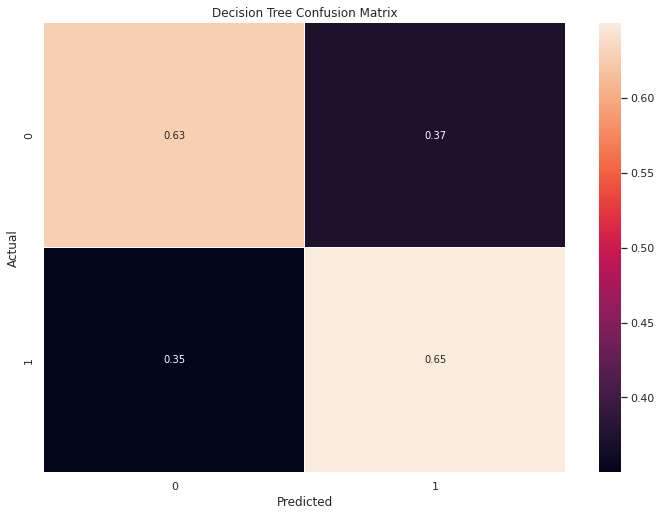

In [ ]:
dt_matrix = confusion_matrix(y_test, y_pred)
dt_matrix = dt_matrix.astype('float') / dt_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(dt_matrix, annot = True, annot_kws = {'size':10}, linewidths = 0.2)
cm_labeler('Decision Tree Confusion Matrix','Predicted','Actual')


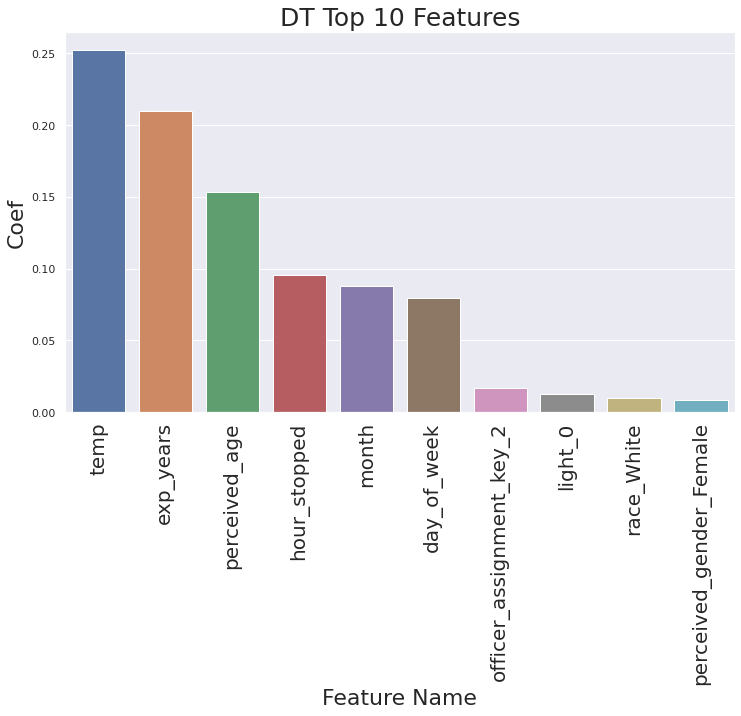

In [ ]:
# retrieve nominal dummy feature names
DT_feature_names = DT_pipeline.named_steps['pipeline'].named_steps['columntransformer'].named_transformers_['nominal'].get_feature_names_out()
DT_feature_names = list(DT_feature_names)

# retrieve continuous feature names
continuous_feature_names = DT_pipeline.named_steps['pipeline'].named_steps['columntransformer'].named_transformers_['num'].feature_names_in_
continuous_feature_names = list(continuous_feature_names)

# combine all names
DT_feature_names = DT_feature_names  + continuous_feature_names

DT_coefs = DT_pipeline.named_steps['decisiontreeclassifier'].feature_importances_

zipped = zip(DT_feature_names, DT_coefs)
dt_coeff_df = pd.DataFrame(zipped, columns=["feature", "value"])

dt_coeff_df = top10plotter(dt_coeff_df, "DT Top 10 Features")

In [ ]:
DT_pipeline.named_steps['decisiontreeclassifier'].tree_.max_depth

50

## Decision Tree w/ out Temp

In [ ]:
DT_pipeline_no_temp = make_pipeline(feature_pipe_no_temp, DecisionTreeClassifier())
cv_scores = cross_val_score(DT_pipeline_no_temp, x_train, y_train, cv=10)
print(f'Mean score {cv_scores.mean()}')
cv_scores

Mean score 0.632778407236468


array([0.63082202, 0.63872628, 0.62939039, 0.63191361, 0.63171175,
       0.63095478, 0.63337707, 0.63186314, 0.63267057, 0.63635446])

Even though temp was shown to be the most important feature, it appears that the feature was given weighted importance simply by chance.  This is proven by the mean scores of both DT models constantly hovering around 63%.

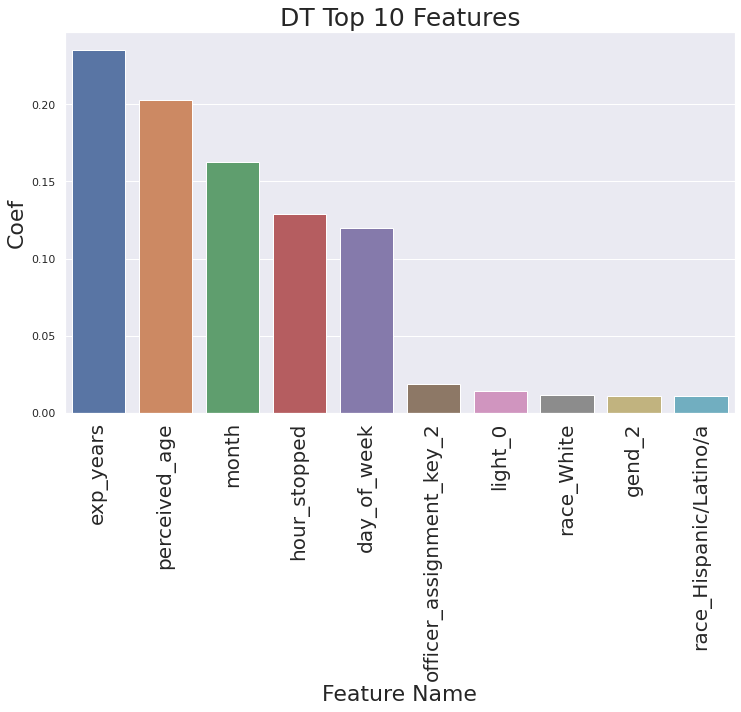

In [ ]:
DT_pipeline_no_temp.fit(x_train, y_train)

# retrieve nominal dummy feature names
DT_feature_names = DT_pipeline_no_temp.named_steps['pipeline'].named_steps['columntransformer'].named_transformers_['nominal'].get_feature_names_out()
DT_feature_names = list(DT_feature_names)

# retrieve continuous feature names
continuous_feature_names = DT_pipeline_no_temp.named_steps['pipeline'].named_steps['columntransformer'].named_transformers_['num'].feature_names_in_
continuous_feature_names = list(continuous_feature_names)

# combine all names
DT_feature_names = DT_feature_names  + continuous_feature_names

DT_coefs = DT_pipeline_no_temp.named_steps['decisiontreeclassifier'].feature_importances_

zipped = zip(DT_feature_names, DT_coefs)
dt_coeff_df = pd.DataFrame(zipped, columns=["feature", "value"])

dt_coeff_df = top10plotter(dt_coeff_df, "DT Top 10 Features")

## Bagging w/ Temp

In [ ]:
params = {
    'baggingclassifier__max_samples' : [0.1, 0.5, 1],
    'baggingclassifier__max_features' : [0.1, 0.5, 1]
}

# utilizes default decision tree params
bag = BaggingClassifier()
bag_pipeline = make_pipeline(feature_pipe, bag)
bag_search = GridSearchCV(bag_pipeline, params, cv=10)

bag_search.fit(x_train,y_train)

gridsearch_df_viewer(bag_search.cv_results_)

,index,param_baggingclassifier__max_features,param_baggingclassifier__max_samples,params,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,4,0.5,0.5,"{'baggingclassifier__max_features': 0.5, 'bagg...",0.674304,0.660678,0.680309,0.665321,0.667693,0.672362,0.006788,1
1,3,0.5,0.1,"{'baggingclassifier__max_features': 0.5, 'bagg...",0.663555,0.671629,0.661132,0.672184,0.691966,0.669874,0.013220,2
2,0,0.1,0.1,"{'baggingclassifier__max_features': 0.1, 'bagg...",0.669459,0.654370,0.690200,0.584830,0.650182,0.646797,0.028522,3
3,1,0.1,0.5,"{'baggingclassifier__max_features': 0.1, 'bagg...",0.680763,0.629945,0.637969,0.614503,0.679754,0.638627,0.026227,4
4,6,1,0.1,"{'baggingclassifier__max_features': 1, 'baggin...",0.574132,0.525283,0.553290,0.589120,0.639534,0.583107,0.046923,5


In [ ]:
params = {
    'baggingclassifier__max_samples' : [0.25, 0.5, .75],
    'baggingclassifier__max_features' : [0.25, 0.5, .75]
}

# utilizes default decision tree params
bag = BaggingClassifier()
bag_pipeline = make_pipeline(feature_pipe, bag)
bag_search = GridSearchCV(bag_pipeline, params, cv=10)

bag_search.fit(x_train,y_train)

gridsearch_df_viewer(bag_search.cv_results_)

,index,param_baggingclassifier__max_features,param_baggingclassifier__max_samples,params,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8,0.75,0.75,"{'baggingclassifier__max_features': 0.75, 'bag...",0.683084,0.689392,0.688181,0.680511,0.683236,0.685372,0.005533,1
1,7,0.75,0.5,"{'baggingclassifier__max_features': 0.75, 'bag...",0.688837,0.679956,0.692117,0.686617,0.690200,0.684918,0.007384,2
2,5,0.5,0.75,"{'baggingclassifier__max_features': 0.5, 'bagg...",0.696811,0.677180,0.685153,0.660527,0.672487,0.681310,0.013806,3
3,4,0.5,0.5,"{'baggingclassifier__max_features': 0.5, 'bagg...",0.684851,0.683084,0.685305,0.679602,0.656237,0.680144,0.009064,4
4,6,0.75,0.25,"{'baggingclassifier__max_features': 0.75, 'bag...",0.683841,0.682025,0.676827,0.674909,0.665977,0.679367,0.006602,5


no improvement! =(

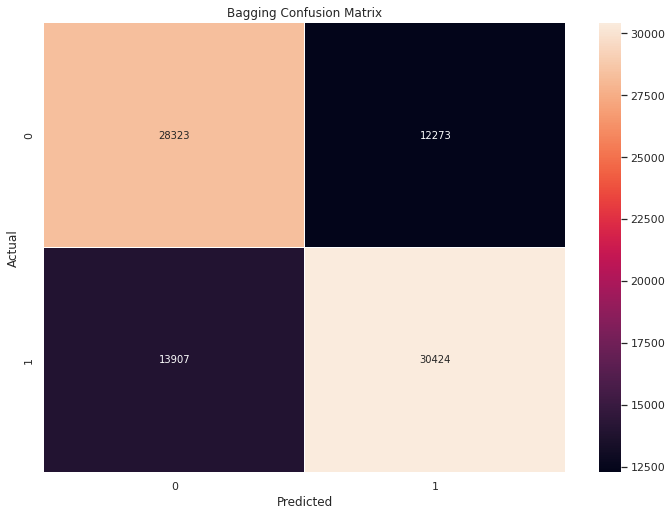

In [ ]:
y_pred = bag_search.predict(x_test)
bag_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(bag_matrix, annot = True, annot_kws = {'size':10}, linewidths = 0.2, fmt='g')
cm_labeler('Bagging Confusion Matrix','Predicted','Actual')

## Bagging w/out Temp
Let's see if the Bagging Classifier w/ default settings show any signs of degradation from having not having `Temp` as a feature.

In [ ]:
params = {
    'baggingclassifier__max_samples' : [0.5, .75],
    'baggingclassifier__max_features' : [0.5, .75]
}

# utilizes default decision tree params
bag = BaggingClassifier()
bag_pipeline = make_pipeline(feature_pipe_no_temp, bag)
bag_search = GridSearchCV(bag_pipeline, params, cv=10)

bag_search.fit(x_train,y_train)

gridsearch_df_viewer(bag_search.cv_results_)

,index,param_baggingclassifier__max_features,param_baggingclassifier__max_samples,params,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1,0.5,0.75,"{'baggingclassifier__max_features': 0.5, 'bagg...",0.703926,0.673042,0.677786,0.707862,0.693379,0.689525,0.011689,1
1,0,0.5,0.5,"{'baggingclassifier__max_features': 0.5, 'bagg...",0.688434,0.675061,0.685809,0.695448,0.695145,0.689308,0.007928,2
2,2,0.75,0.5,"{'baggingclassifier__max_features': 0.75, 'bag...",0.682983,0.690654,0.690250,0.680662,0.695499,0.684913,0.008705,3
3,3,0.75,0.75,"{'baggingclassifier__max_features': 0.75, 'bag...",0.682529,0.681116,0.682176,0.689039,0.675818,0.684146,0.005182,4


Not any different and thus it appears that weather is not an influence, or at least with the way the dataset is setup there is no influence.  Maybe for some certain crimes, weather has an influce, but since most people utilize AC within their cars, temperature is not that much of a concern.

## AdaBoost

In [ ]:
params = {
    'adaboostclassifier__learning_rate' : [0.25, 0.5, 1],
    'adaboostclassifier__n_estimators' : [50,100,150]
}

adaboost = AdaBoostClassifier()
ada_pipeline = make_pipeline(feature_pipe, adaboost)
ada_search = GridSearchCV(ada_pipeline, params, cv=10)
ada_search.fit(x_train, y_train)
gridsearch_df_viewer(ada_search.cv_results_)

,index,param_adaboostclassifier__learning_rate,param_adaboostclassifier__n_estimators,params,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8,1,150,"{'adaboostclassifier__learning_rate': 1, 'adab...",0.703371,0.702917,0.701958,0.706046,0.702866,0.701914,0.003230,1
1,7,1,100,"{'adaboostclassifier__learning_rate': 1, 'adab...",0.703371,0.702362,0.700999,0.703825,0.701807,0.701409,0.002926,2
2,2,0.25,150,"{'adaboostclassifier__learning_rate': 0.25, 'a...",0.703472,0.703724,0.700646,0.703825,0.700444,0.700799,0.003812,3
3,1,0.25,100,"{'adaboostclassifier__learning_rate': 0.25, 'a...",0.702765,0.702765,0.701453,0.703421,0.699637,0.700592,0.003917,4
4,5,0.5,150,"{'adaboostclassifier__learning_rate': 0.5, 'ad...",0.702665,0.701655,0.700898,0.703522,0.701100,0.700541,0.003295,5


In [ ]:
y_pred = ada_search.predict(x_test)

ada_report, ada_printout = class_reporter(y_test, y_pred, 'AdaBoost')
print(ada_printout)

              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71     40596
         1.0       0.74      0.66      0.70     44331

    accuracy                           0.70     84927
   macro avg       0.70      0.70      0.70     84927
weighted avg       0.71      0.70      0.70     84927



## AdaBoost w/out Temp

In [ ]:
params = {
    'adaboostclassifier__learning_rate' : [0.25, 0.5, 1],
    'adaboostclassifier__n_estimators' : [50,100,150]
}

adaboost = AdaBoostClassifier()
ada_pipeline = make_pipeline(feature_pipe_no_temp, adaboost)
ada_search = GridSearchCV(ada_pipeline, params, cv=10)
ada_search.fit(x_train, y_train)
gridsearch_df_viewer(ada_search.cv_results_)

## KNN

In [ ]:
knn_pipeline = make_pipeline(feature_pipe, KNeighborsClassifier())

# params={'kneighborsclassifier__n_neighbors':list(np.arange(3,17,2))}
params={'kneighborsclassifier__n_neighbors':[7]}

knn_standard_scale_search = GridSearchCV(knn_pipeline,params,scoring='recall', cv=10, n_jobs=-1)
knn_standard_scale_search.fit(x_train, y_train)

gridsearch_df_viewer(knn_standard_scale_search.cv_results_)

,index,param_kneighborsclassifier__n_neighbors,params,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0,7,{'kneighborsclassifier__n_neighbors': 7},0.682721,0.681461,0.685435,0.679717,0.684756,0.682246,0.004934,1


In [ ]:
y_pred = knn_standard_scale_search.predict(x_test)

knn_standard_report, knn_standard_printout =  class_reporter(y_test, y_pred,'knn_standard')
print(knn_standard_printout)

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67     40596
         1.0       0.69      0.68      0.69     44331

    accuracy                           0.68     84927
   macro avg       0.68      0.68      0.68     84927
weighted avg       0.68      0.68      0.68     84927



# Lift Chart Comparison

In [40]:
# ada_probs = ada_search.predict_proba(x_test)
bag_probs = bag_search.predict_proba(x_test)
dt_probs = DT_pipeline.predict_proba(x_test)
knn_probs = knn_standard_scale_search.predict_proba(x_test)

In [41]:
%%capture
!pip install dmba

no display found. Using non-interactive Agg backend


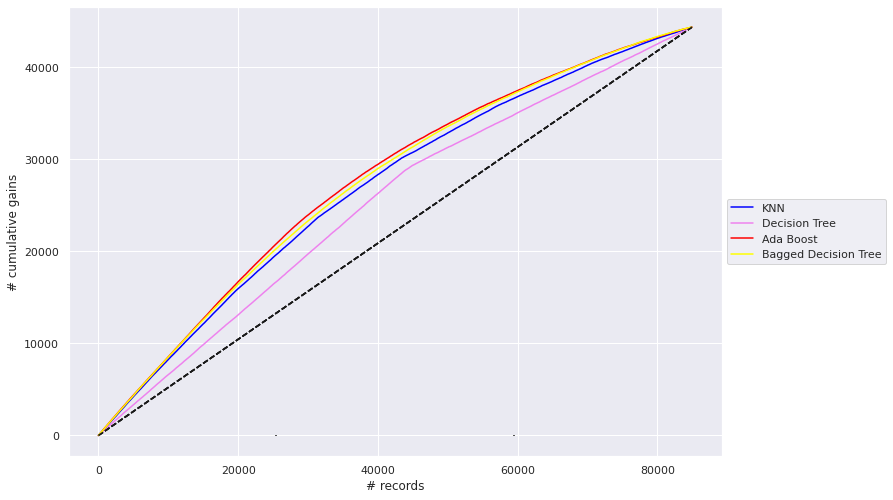

In [42]:
from dmba import classificationSummary, gainsChart

def addLiftChart(predict_proba, label, ax=None, color="blue"):
    df = pd.DataFrame(data={'prob': [p[1] for p in predict_proba], 'actual': y_test})
    df = df.sort_values(by=['prob'], ascending=False)
    ax = gainsChart(df.actual, ax=ax, label=label, color=color)
    return ax

ax = addLiftChart(knn_probs, 'KNN')
addLiftChart(dt_probs, 'Decision Tree', ax=ax, color='violet')
addLiftChart(ada_probs, 'Ada Boost', ax=ax, color='red')
addLiftChart(bag_probs, 'Bagged Decision Tree', ax=ax, color='yellow')

ax.vlines(x=[len(y_test) * 0.3, len(y_test) * 0.7], ymin=-40, ymax=80, linestyles='dotted')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()